## Prepare text

In [1]:
from datasets import load_dataset
from shuffle_iter import *


datasets = [
    load_dataset(k, split="train", streaming=True)
    for k in (
        "ChristophSchuhmann/wikipedia-en-nov22-1-sentence-level",
        "ChristophSchuhmann/1-sentence-level-gutenberg-en_arxiv_pubmed_soda",
    )
]
shuffled_dataset_iters = [DatasetShuffleIterator(k) for k in datasets]


## Prepare fonts

In [1]:
from typing import IO
import zipfile
from pathlib import PurePath as ppth
from pathlib import Path as pth
import tempfile

import gdown


class Fonts:
    def __init__(self):
        self.zip_path = pth(tempfile.mkdtemp())

        self.zip_file = None
        self.font_list = []
        self.font_path_iter = iter([])

    def download_fonts(self, *gdrive_IDs: str):
        for k in gdrive_IDs:
            print(f"Downloading {k}")
            path = self.zip_path / f"{k}.zip"
            gdown.download(id=k, output=str(path), quiet=False)

            self.zip_file = zipfile.ZipFile(path, "r")
            self.font_list = [ppth(k) for k in self.zip_file.namelist() if k.lower().endswith((".otf", ".ttf"))]

    def get_font_by_path(self, path: pth) -> IO[bytes] or None:
        return self.zip_file.open(path.as_posix())

#### Download

In [2]:
fonts = Fonts()
fonts.download_fonts("1xx1XX96fwInOKFxvaTE0XixzleSRWDEN")
random_font_iter = ShuffleIterator(fonts.font_list)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1xx1XX96fwInOKFxvaTE0XixzleSRWDEN
From (redirected): https://drive.google.com/uc?id=1xx1XX96fwInOKFxvaTE0XixzleSRWDEN&confirm=t&uuid=199eabcb-f746-465f-8a88-b07f0b0d5237
To: C:\Users\GbotHQ\AppData\Local\Temp\tmpc7a5i703\1xx1XX96fwInOKFxvaTE0XixzleSRWDEN.zip
100%|██████████| 475M/475M [04:29<00:00, 1.76MB/s] 


NameError: name 'ShuffleIterator' is not defined

## Prepare text rendering

In [ ]:
from typing import Tuple

from Blender_3D_document_rendering_pipeline.src import config
from bounding_box import *


class SampleInfo:
    def __init__(
        self,
        text: str,
        config: config.Config,
        image_path: pth,
        mask_image_path: pth,
        font_path: str,
        font_color: Tuple[int, int, int],
        font_size: int,
        text_rotation_angle: int,
        text_image_resolution: Tuple[int, int],
        output_image_resolution: Tuple[int, int],
        output_image_path: pth,
        output_coordinates_path: pth
    ):
        self.text = text
        self.config = config
        self.image_path = image_path
        self.mask_image_path = mask_image_path
        self.font_path = font_path
        self.font_color = font_color
        self.font_size = font_size
        self.text_rotation_angle = text_rotation_angle
        self.text_image_resolution = text_image_resolution
        self.output_image_resolution = output_image_resolution
        self.output_image_path = output_image_path
        self.output_coordinates_path = output_coordinates_path

In [ ]:
import concurrent.futures
from random import uniform, randint, random, choice
import textwrap
from colorsys import hls_to_rgb

from fontTools.ttLib import TTFont
import numpy as np
import cv2 as cv
from PIL import Image, ImageFont, ImageDraw
from PIL.Image import Resampling


def imshow(img):
    if isinstance(img, np.ndarray):
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
    display(img)


def lerp(a, b, fac):
    return a + (b - a) * fac


def pad_image(
    img: np.ndarray, padding: Tuple[int, int, int, int] = (0, 0, 0, 0), color: int = 255
):
    return np.pad(
        img, (padding[:2], padding[2:], (0, 0)), mode="constant", constant_values=color
    )


def wrap_text_to_match_aspect_ratio(text: str, font: ImageFont, aspect_ratio: float):
    # calculate line character width based on aspect ratio
    n_characters = len(text)

    text_bbox = font.getbbox(text)
    text_bbox = SimpleBoundingBox(text_bbox[:2], text_bbox[2:], np.int32)
    character_size = text_bbox.get_size()
    character_size[0] /= n_characters

    text_area = character_size[0] * character_size[1] * n_characters

    size = np.ceil(
        np.array(
            (text_area**0.5 * aspect_ratio, text_area**0.5 / aspect_ratio),
            np.float32,
        )
        / character_size
    ).astype(np.int32)

    # wrap text based on calculated width
    return textwrap.fill(text=text, width=size[0], break_long_words=False, break_on_hyphens=False)


def calculate_font_scale(text: str, font: ImageFont, resolution: int, draw: ImageDraw):
    # find font scale that roughly matches resolution
    text_bbox = draw.multiline_textbbox((0, 0), text, font=font)
    text_bbox = SimpleBoundingBox(text_bbox[:2], text_bbox[2:], np.int32)

    return resolution / np.amax(text_bbox.get_size())


def apply_colors(color0, color1, alpha):
    # to float
    alpha = alpha.astype(np.float32) / 255
    img = lerp(color0, color1, alpha)
    # to uint
    img = np.rint(img).astype(np.uint8)
    return cv.cvtColor(img, cv.COLOR_RGB2BGR)


def render_text_mask(
    text: str,
    font: ImageFont,
    resolution: int,
    text_aspect_ratio: float,
    alignment: str = "left",
) -> Tuple[str, np.ndarray]:
    text = wrap_text_to_match_aspect_ratio(text, font, text_aspect_ratio)

    # temp draw for getting font bbox
    draw = ImageDraw.Draw(Image.new("RGB", (0, 0)))
    font_scale = calculate_font_scale(text, font, resolution, draw)
    font_size = int(font.size * font_scale)
    # scale font
    font = font.font_variant(size=font_size)

    # calculate image resolution
    text_bbox = draw.multiline_textbbox((0, 0), text, font=font)
    text_bbox = SimpleBoundingBox(text_bbox[:2], text_bbox[2:], np.int32)
    # render text
    alpha = Image.new("RGB", text_bbox.get_size().tolist(), color=(255, 255, 255))
    draw = ImageDraw.Draw(alpha)
    draw.text((-text_bbox[0][:]).tolist(), text, fill=(0, 0, 0), font=font, align=alignment)

    return text, alpha, font_size


def render_text(
    text: str,
    font: ImageFont,
    resolution: int,
    text_aspect_ratio: float,
    angle: int = 0,
    padding: Tuple[int, int, int, int] = (0, 0, 0, 0),
    alignment: str = "left",
    font_color: Tuple[int, int, int] = (0, 0, 0),
    background_color: Tuple[int, int, int] = (255, 255, 255),
) -> Tuple[str, np.ndarray, Tuple[Tuple[int, int], Tuple[int, int]]]:
    white = (255, 255, 255)

    text, alpha, font_size = render_text_mask(text, font, resolution, text_aspect_ratio, alignment)

    # rotate image
    alpha = alpha.rotate(angle, resample=Resampling.BICUBIC, expand=True, fillcolor=white)
    # to opencv
    alpha = np.array(alpha)
    # add padding
    alpha = pad_image(alpha, padding, white[0])
    # apply colors
    img = apply_colors(font_color, background_color, alpha)

    return text, img, alpha, font_size


def is_char_supported_by_font(font: TTFont, char: str) -> bool:
    return any(ord(char) in k.cmap.keys() for k in font['cmap'].tables if hasattr(k, "cmap"))


def is_text_supported_by_font(text: str, font: TTFont):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        return all(executor.map(lambda c: is_char_supported_by_font(font, c), text))


def hls_to_int_rgb(h: float, l: float, s: float):
    col = hls_to_rgb(h, l, s)
    return np.floor(np.array(col, np.float32) * 255).astype(np.int32)


def generate(text: str, font: ImageFont):
    h, l, s = [random() for _ in range(3)]
    # make saturation curve steeper
    s = (s ** 2) * (3 - 2 * s)
    font_color = hls_to_int_rgb(h, l * 0.6, s * 0.86)

    text_rotation_angle = randint(-45, 45)

    aspect_ratio = uniform(0.5, 2)
    padding = [randint(0, 64) for _ in range(4)]
    alignment = choice(["left", "center", "right"])

    return *render_text(
        text, font, 512, aspect_ratio, text_rotation_angle, padding, alignment, font_color
    ), font_color, text_rotation_angle

## Render text and randomize Blender scene

In [ ]:
root_dir = pth.cwd() / "Blender_3D_document_rendering_pipeline"

blender_path = "C:/Program Files/Blender Foundation/Blender 3.4/blender" # path to the blender binary
blend_file_path = root_dir / "blender" / "scene.blend"
script_path = root_dir / "src" / "main.py"
output_dir_path = root_dir / "renders"
config_dir_path = root_dir / "config"

In [ ]:
from shutil import rmtree
import itertools
import re
import threading
import multiprocessing
from io import BytesIO
from random import choice

from tqdm import tqdm


def mkdir(path: pth):
    if path.is_dir():
        rmtree(path)
    path.mkdir(parents=True)


image_dir_path = pth(tempfile.mkdtemp())
print(image_dir_path)

mkdir(config_dir_path)
mkdir(image_dir_path)


text_lock = threading.Lock()
font_lock = threading.Lock()


def preprocess_text(_):
    # break up sentences
    with text_lock:
        text_sample = next(shuffled_dataset_iters[randint(0, 1)])["sentences"]
    
    # make sure that punctuation has the correct spacing
    text_sample = re.sub(r'\s*([.,])\s*', r'\1 ', text_sample)

    text_sample = [k.strip() for k in text_sample.split(", ")]
    text_sample = [k for k in text_sample if k]

    # randomly merge back some adjecent strings
    i = 0
    while (i + 1) < len(text_sample):
        if random() < 0.15:
            text_sample[i] += f", {text_sample.pop(i + 1)}"
        i += 1

    return text_sample


n_samples = 8

# get the number of CPU cores available
n_cores = multiprocessing.cpu_count()
# n_cores = 1

with concurrent.futures.ThreadPoolExecutor(max_workers=n_cores) as executor:
    text_samples = executor.map(preprocess_text, range(n_samples))
    # flatten
    text_samples = itertools.chain.from_iterable(text_samples)


def generate_sample(index: int):
    while True:
        # find a font that supports all characters in text
        with text_lock:
            text = next(text_samples)
        for _ in range(20):
            with font_lock:
                font_path = next(random_font_iter)
            font_file = fonts.get_font_by_path(font_path).read()
            # few fonts are be broken and will raise an exception
            try:
                if is_text_supported_by_font(text, TTFont(BytesIO(font_file))):
                    break
            except Exception as e:
                print(e)
                continue
        else:
            # give up and try a different piece of text
            print("No font found that supports all characters in text")
            continue
        break

    # few fonts are be broken and will raise an exception
    try:
        font = ImageFont.truetype(BytesIO(font_file), 42)
        text, img, mask, font_size, font_color, text_rotation_angle = generate(
            text, font
        )
    except Exception as e:
        print(f"Error while generating sample {index}: {e}")
        return

    image_path = image_dir_path / f"sample_{index:08d}.png"
    cv.imwrite(str(image_path), img, [cv.IMWRITE_PNG_COMPRESSION, 9])
    
    mask_image_path = image_dir_path / f"sample_{index:08d}_mask.png"
    cv.imwrite(str(mask_image_path), mask, [cv.IMWRITE_PNG_COMPRESSION, 9])

    output_image_resolution = (512, 512)
    resolution = np.array(img.shape[:2], np.float32)
    paper_size = resolution[::-1] / np.mean(resolution) * 25

    conf = config.Config(project_root=root_dir)
    conf.render.resolution = output_image_resolution
    conf.paper.document_image_path = str(image_path.resolve(True))
    conf.paper.size = paper_size.tolist()
    config_path = config_dir_path / f"sample_{index:08d}.json"
    config.write_config(config_path, conf)

    out_dir = output_dir_path / f"sample_{index:08d}"
    out_image_path = out_dir / "image0001.png"
    out_coordinates_path = out_dir / "coordinates0001.png"

    resolution = tuple(resolution.tolist())

    return SampleInfo(
        text,
        conf,
        image_path,
        mask_image_path,
        font_path,
        font_color,
        font_size,
        text_rotation_angle,
        resolution,
        output_image_resolution,
        out_image_path,
        out_coordinates_path,
    )


with concurrent.futures.ThreadPoolExecutor(max_workers=n_cores) as executor:
    generated_samples = list(
        tqdm(
            executor.map(generate_sample, range(n_samples)),
            total=n_samples,
            desc="Generating samples",
        )
    )

# remove failed samples
generated_samples = [k for k in generated_samples if k]

C:\Users\GbotHQ\AppData\Local\Temp\tmpk89b5tc1


Generating samples:   4%|▍         | 39/1024 [00:05<02:45,  5.96it/s]

Error while generating sample 235: too many function definitions


Generating samples:  12%|█▏        | 121/1024 [00:33<04:31,  3.33it/s]

No font found that supports all characters in text
Not a TrueType or OpenType font (bad sfntVersion)
No font found that supports all characters in text
No font found that supports all characters in text
No font found that supports all characters in text


Generating samples: 100%|██████████| 1024/1024 [01:27<00:00, 11.70it/s]


In [ ]:
import multiprocessing
from io import BytesIO

from tqdm import tqdm


image_dir_path = pth(tempfile.mkdtemp())
print(image_dir_path)
mkdir(image_dir_path)

n_samples = len(fonts.font_list)

# get the number of CPU cores available
n_cores = multiprocessing.cpu_count()


font_iter = iter(fonts.font_list)
def generate_sample(font_path):
    text = """escapism became the dominant form of science fiction film through the 1980s, the big budget adaptations of Frank Herbert's "Dune" 1984 and Arthur C. Clarke's sequel to "2001"."""
    
    font_file = fonts.get_font_by_path(font_path).read()
    # few fonts are be broken and will raise an exception
    try:
        if not is_text_supported_by_font(text, TTFont(BytesIO(font_file))):
            return
        
        font = ImageFont.truetype(BytesIO(font_file), 42)
        text, img, mask, font_size, font_color, text_rotation_angle = generate(
            text, font
        )
    except Exception as e:
        print(f"Error while generating sample {str(font_path.name)}: {e}")
        return

    image_path = image_dir_path / f"{str(font_path.name)}.png"
    cv.imwrite(str(image_path), img, [cv.IMWRITE_PNG_COMPRESSION, 9])


with concurrent.futures.ThreadPoolExecutor(max_workers=n_cores) as executor:
    generated_samples = list(
        tqdm(
            executor.map(generate_sample, fonts.font_list),
            total=n_samples,
            desc="Generating samples",
        )
    )

C:\Users\GbotHQ\AppData\Local\Temp\tmp_q3v5fgx
Error while generating sample ._Harrowprint.ttf: Not a TrueType or OpenType font (bad sfntVersion)
Error while generating sample ._Red Lightning.ttf: Not a TrueType or OpenType font (bad sfntVersion)


C:\Users\GbotHQ\AppData\Local\Temp\ipykernel_25368\183645541.py:44: RuntimeWarning: invalid value encountered in divide
  np.array(
C:\Users\GbotHQ\AppData\Local\Temp\ipykernel_25368\183645541.py:49: RuntimeWarning: invalid value encountered in cast
  ).astype(np.int32)


Error while generating sample AkamiGothicKana-vm0M7.ttf: invalid width 0 (must be > 0)
Error while generating sample AliceRomanDemo-ALe22.ttf: too many function definitions


Generating samples:  12%|█▏        | 1123/9577 [01:01<09:00, 15.65it/s]

Error while generating sample Belal-eZgJm.ttf: too many function definitions


Generating samples:  17%|█▋        | 1611/9577 [01:40<07:36, 17.45it/s]

Error while generating sample BreadyDemoItalic-JRM97.ttf: too many function definitions


Generating samples:  17%|█▋        | 1618/9577 [01:41<11:45, 11.29it/s]

Error while generating sample BreadyDemo-GO8Pm.ttf: too many function definitions


Generating samples:  23%|██▎       | 2192/9577 [02:25<12:16, 10.02it/s]C:\Users\GbotHQ\AppData\Local\Temp\ipykernel_25368\183645541.py:44: RuntimeWarning: invalid value encountered in divide
  np.array(
C:\Users\GbotHQ\AppData\Local\Temp\ipykernel_25368\183645541.py:49: RuntimeWarning: invalid value encountered in cast
  ).astype(np.int32)


Error while generating sample ChristophersScribble.otf: invalid width 0 (must be > 0)


Generating samples:  28%|██▊       | 2639/9577 [03:00<07:38, 15.12it/s]cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
Generating samples:  38%|███▊      | 3601/9577 [04:21<10:33,  9.44it/s]

Error while generating sample FunClimbingDemoItalic-2O5wl.ttf: too many function definitions
Error while generating sample FunClimbingDemo-vm7o7.ttf: too many function definitions


Generating samples:  39%|███▊      | 3695/9577 [04:30<08:27, 11.59it/s]

Error while generating sample GesturallyDemoItalic-RpPRv.ttf: too many function definitions


Generating samples:  39%|███▊      | 3701/9577 [04:31<09:38, 10.15it/s]

Error while generating sample GesturallyDemo-BWl4G.ttf: too many function definitions


Generating samples:  39%|███▉      | 3739/9577 [04:33<04:37, 21.02it/s]

Error while generating sample GinSSB60.ttf: max() arg is an empty sequence


Generating samples:  41%|████      | 3933/9577 [04:52<13:24,  7.01it/s]

Error while generating sample GrowmingDemo-0W59R.ttf: too many function definitions


Generating samples:  41%|████      | 3940/9577 [04:53<09:38,  9.74it/s]

Error while generating sample GrowmingDemoItalic-4B5mx.ttf: too many function definitions


Generating samples:  44%|████▍     | 4254/9577 [06:17<21:14,  4.18it/s]  

Error while generating sample HerbalMedicineDemoItalic-w1m48.ttf: too many function definitions


Generating samples:  45%|████▍     | 4263/9577 [06:19<24:30,  3.61it/s]

Error while generating sample HerbalMedicineDemo-7B5LR.ttf: too many function definitions


Generating samples:  46%|████▌     | 4362/9577 [06:48<28:12,  3.08it/s]cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
Generating samples:  46%|████▋     | 4433/9577 [07:07<16:18,  5.26it/s]

Error while generating sample HumanistSignatureDemo-2OM83.ttf: too many function definitions


Generating samples:  46%|████▋     | 4449/9577 [07:14<36:17,  2.35it/s]

Error while generating sample HumanistSignatureDemoItalic-K7KxZ.ttf: too many function definitions


Generating samples:  57%|█████▋    | 5478/9577 [10:08<12:08,  5.63it/s]

Error while generating sample LostefaMesmerizeDemo-Wy8jE.ttf: too many function definitions


Generating samples:  57%|█████▋    | 5490/9577 [10:10<11:09,  6.10it/s]

Error while generating sample LostefaMesmerizeDemoItalic-eZgR6.ttf: too many function definitions


Generating samples:  63%|██████▎   | 6047/9577 [11:35<08:35,  6.85it/s]

Error while generating sample MingkungDemo-OVoj4.ttf: too many function definitions


Generating samples:  63%|██████▎   | 6054/9577 [11:37<13:20,  4.40it/s]

Error while generating sample MingkungDemoItalic-Ea2jn.ttf: too many function definitions


Generating samples:  75%|███████▍  | 7158/9577 [14:41<05:29,  7.35it/s]cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
Generating samples:  79%|███████▉  | 7601/9577 [16:04<06:00,  5.48it/s]cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
Generating samples:  83%|████████▎ | 7942/9577 [17:06<02:59,  9.09it/s]cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
cmap subtable is reported as having zero length: platformID 1, platEncID 0, format 0 offset 20. Skipping table.
Generating samples:  98%|█████████▊| 9373/9577 [22:01<01:01,  3.32it/s]

Error while generating sample WomenFrameDemo-ALYKL.ttf: too many function definitions


Generating samples:  99%|█████████▉| 9470/9577 [22:19<00:12,  8.37it/s]

Error while generating sample yleeMortalHeartImmortalMemoryv.1.1OTF.otf: illegal use of getGlyphOrder()


Generating samples:  99%|█████████▉| 9474/9577 [22:21<00:26,  3.89it/s]

Error while generating sample yleeMortalHeartImmortalMemoryv.1.1TTF.ttf: illegal use of getGlyphOrder()


Generating samples: 100%|██████████| 9577/9577 [22:36<00:00,  7.06it/s]


#### Show a random sample

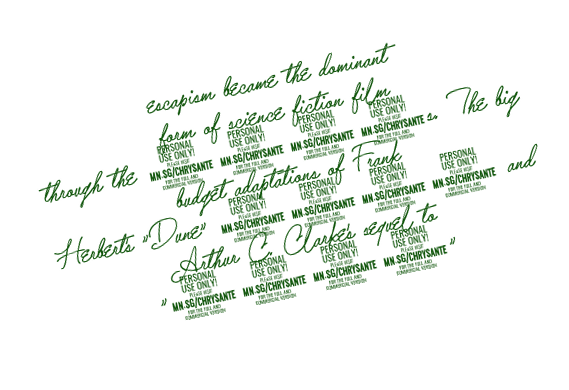

escapism became the dominant
form of science fiction film
through the 1980s. The big
budget adaptations of Frank
Herbert's "Dune" 1984 and
Arthur C. Clarke's sequel to
"2001"


In [ ]:
# sample = choice(generated_samples)
sample = generated_samples[140]
img = cv.imread(str(sample.image_path))
imshow(img)
print(sample.text)

## Render samples using Blender

In [ ]:
mkdir(output_dir_path)
device = "OPTIX" # either CPU, CUDA or OPTIX

!"$blender_path" "$blend_file_path" --background --factory-startup --threads 0 --engine CYCLES --enable-autoexec --python "$script_path" -- --cycles-device "$device"

Blender 3.4.0 (hash a95bf1ac01be built 2022-12-07 02:06:25)
Read blend: f:\GbotHQ\Documents\GitHub\ocr-dataset-rendering\src\Blender_3D_document_rendering_pipeline\blender\scene.blend
WARN (bke.anim_sys): C:\Users\blender\git\blender-v340\blender.git\source\blender\blenkernel\intern\anim_sys.c:4192 BKE_animsys_eval_driver: invalid driver - modifiers["UVWarp"].offset[0]
WARN (bke.anim_sys): C:\Users\blender\git\blender-v340\blender.git\source\blender\blenkernel\intern\anim_sys.c:4192 BKE_animsys_eval_driver: invalid driver - modifiers["GeometryNodes.003"]["Input_2"][0]
Generating 16 samples...
Failed to enable OPTIX, falling back to CUDA (when rendering from a command line, use [--engine CYCLES] with [--cycles-device OPTIX] and ignore this message)
Failed to enable CUDA, falling back to CPU (when rendering from a command line, use [--engine CYCLES] with [--cycles-device CUDA] and ignore this message)
Fra:1 Mem:35.23M (Peak 49.70M) | Time:00:02.01 | Mem:0.00M, Peak:0.00M | Scene, View La

## Calculate bboxes

In [ ]:
from scipy.ndimage import map_coordinates


def to_uint(img, dtype=np.uint8):
    return (np.clip(img, 0, 1) * np.iinfo(dtype).max).astype(dtype)


def to_float(img, fdtype=np.float32):
    return img.astype(fdtype) / np.iinfo(img.dtype).max


def imread_coords(path):
    # unchanged to read as uint16
    coords = to_float(cv.imread(path, cv.IMREAD_UNCHANGED))
    alpha = coords[..., 0, None]
    # flip y to match opencv coordinates
    coords[..., 1] = 1 - coords[..., 1]
    coords = np.where(alpha < 1, -1, coords[..., 1:])
    coords = coords[..., ::-1]

    return coords, alpha


def calculate_bbox(
    img: np.ndarray, background_color: int, tolerance: int = 12
) -> SimpleBoundingBox:
    mask = np.abs(img.astype(np.int32) - background_color) > tolerance
    mask = (mask.any(0), mask.any(1))
    bbox = [(np.argmax(k), k.size - np.argmax(k[::-1])) for k in mask]
    bbox = np.swapaxes(np.array(bbox, np.int32), 0, 1)
    bbox = SimpleBoundingBox(bbox[0], bbox[1], bbox.dtype)
    # convert from yx to xy
    bbox.points = bbox.points[:, ::-1]
    return bbox


def sample_calculate_bbox(k):
    coords, _ = imread_coords(str(k.output_coordinates_path))
    mask_image = cv.imread(str(k.mask_image_path))[..., 0]

    new_coords = coords[..., ::-1]
    new_coords = np.moveaxis(new_coords, -1, 0)
    new_coords_absolute = new_coords * np.array(mask_image.shape[:2], coords.dtype)[:, None, None]

    warped_image = map_coordinates(mask_image, new_coords_absolute, cval=255)
    k.bbox = calculate_bbox(warped_image, 255)
    k.bbox_relative_xxyy = k.bbox.relative(coords.shape[:2][::-1]).xxyy()


with concurrent.futures.ThreadPoolExecutor(max_workers=n_cores) as executor:
    # Use the map method to apply the process_sample function to each generated sample in parallel
    futures = list(executor.map(sample_calculate_bbox, generated_samples))

## visualize first few generated samples

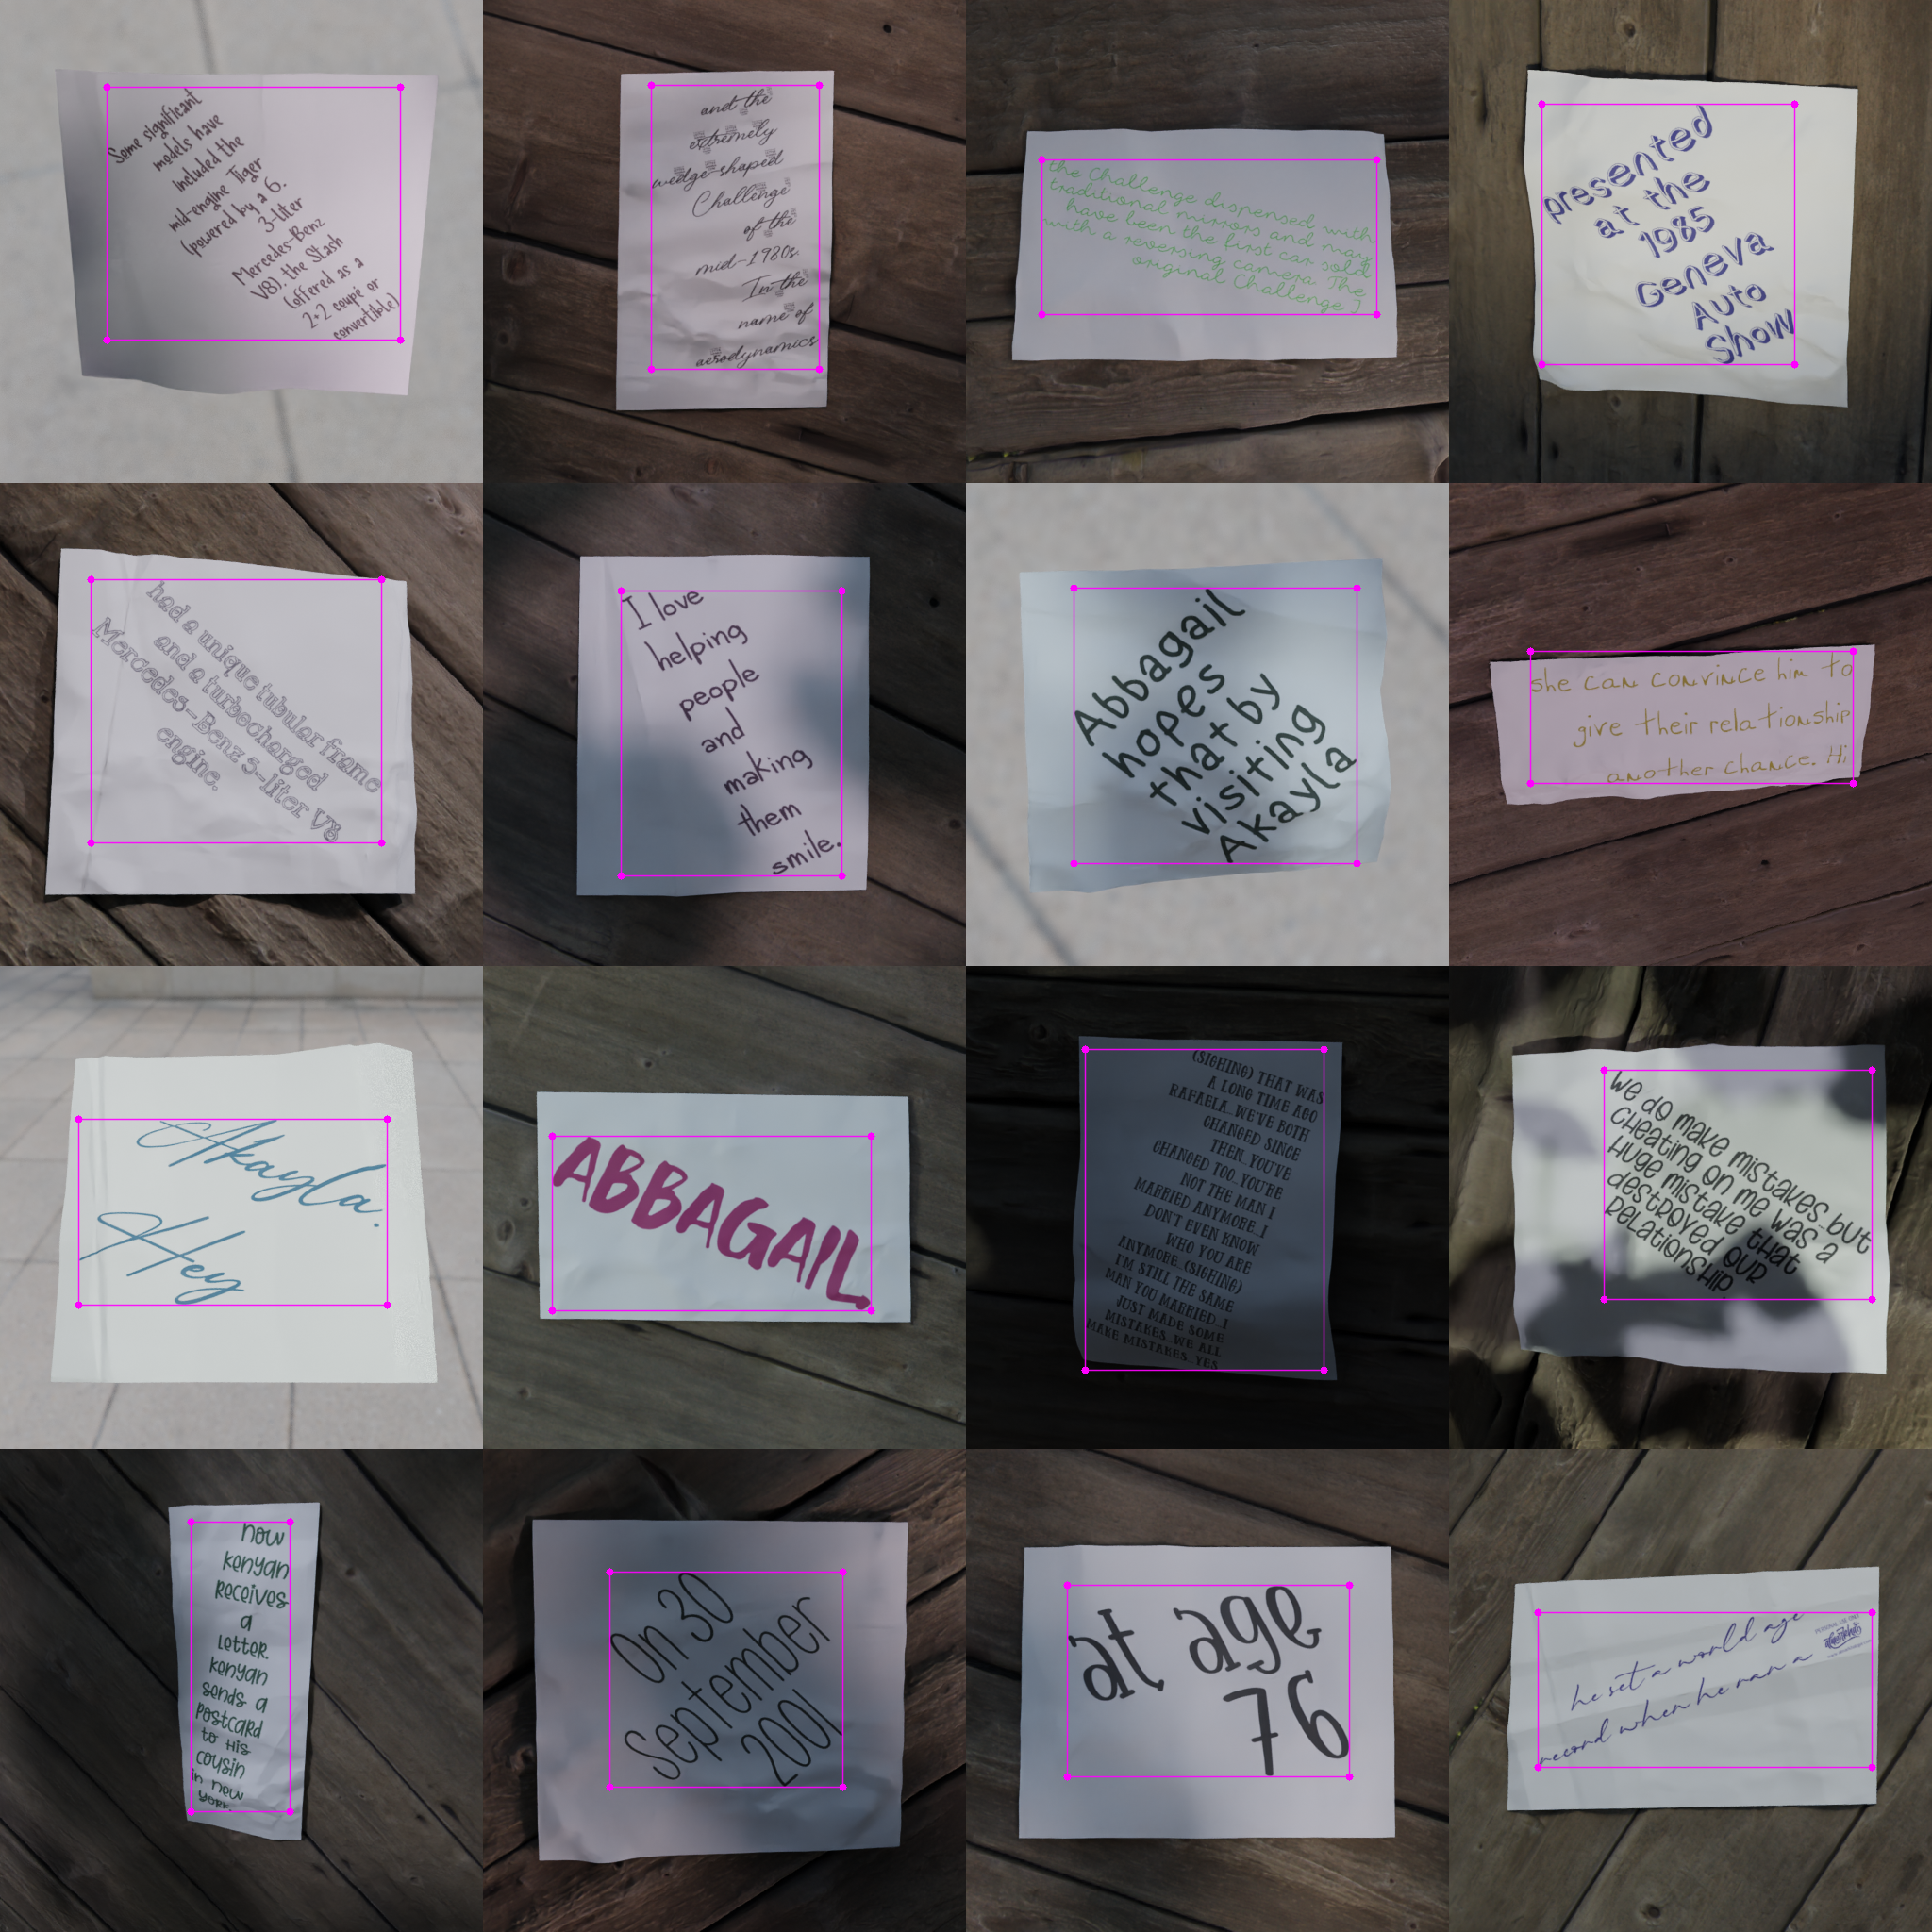

In [ ]:
import math
from typing import Iterable


def make_grid(images: Iterable[np.ndarray]) -> np.ndarray:
    resolution = images[0].shape[:2]
    n_images = len(images)
    grid_size = n_images ** 0.5
    grid_size = math.ceil(grid_size)


    img = np.full((resolution[0] * grid_size, resolution[1] * grid_size, 3), 0, dtype=np.uint8)

    for x in range(grid_size):
        for y in range(grid_size):
            i = x * grid_size + y
            if i >= n_images:
                break
            img[x * resolution[0]:(x + 1) * resolution[0], y * resolution[1]:(y + 1) * resolution[1]] = images[i]
        else:
            continue
        break
    
    return img


number = min(len(generated_samples), 16)
output_imgs = [k.bbox.draw(cv.imread(str(k.output_image_path))) for k in generated_samples[:number]]
img = make_grid(output_imgs)
imshow(img)